In [1]:
%pylab inline

from __future__ import (division, print_function)

import os
import sys
import copy
import fnmatch
import warnings
import collections

import numpy as np
import scipy
try:
    from scipy.stats import scoreatpercentile
except:
    scoreatpercentile = False
from scipy.interpolate import interp1d
import cPickle as pickle

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar

# AstroML
from astroML.plotting import hist

# Matplotlib related
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator
# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 2.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 2.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 2.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 2.5

# Personal
import hscUtils as hUtil
import galSBP

import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Absolute magnitude of sun in HSC filters

# Actuall borrowed from DES filters
# Values from magsun.data in FSPS
amag_sun_des_g = 5.08
amag_sun_des_r = 4.62
amag_sun_des_i = 4.52
amag_sun_des_z = 4.52
amag_sun_des_y = 4.51

# Based on http://www.baryons.org/ezgal/filters.php
amag_sun_ukiss_y = 4.515

# Extinction correction factor for HSC 
## A\_lambda = Coeff * E(B-V) 

a_hsc_g = 3.233
a_hsc_r = 2.291 
a_hsc_i = 1.635
a_hsc_z = 1.261
a_hsc_y = 1.076

# 
SIGMA1 = 0.3173
SIGMA2 = 0.0455
SIGMA3 = 0.0027

RSMA_COMMON = np.arange(0.4, 4.2, 0.02)

In [3]:
# Code for Get Bootstrap mean or median 
def _confidence_interval_1d(A, alpha=.05, metric=np.mean, numResamples=10000, interpolate=True):
    """Calculates bootstrap confidence interval along one dimensional array"""
    
    if not isinstance(alpha, collections.Iterable):
        alpha = np.array([alpha])

    N = len(A)
    resampleInds = np.random.randint(0, N, (numResamples,N))
    metricOfResampled = metric(A[resampleInds], axis=-1)

    confidenceInterval = np.zeros(2*len(alpha),dtype='float')
    
    if interpolate:
        for thisAlphaInd, thisAlpha in enumerate(alpha):
            confidenceInterval[2*thisAlphaInd] = scoreatpercentile(metricOfResampled, 
                                                                   thisAlpha*100/2.0)
            confidenceInterval[2*thisAlphaInd+1] = scoreatpercentile(metricOfResampled, 
                                                                     100-thisAlpha*100/2.0)
    else:
        sortedMetricOfResampled = np.sort(metricOfResampled)
        for thisAlphaInd, thisAlpha in enumerate(alpha):
            confidenceInterval[2*thisAlphaInd] = sortedMetricOfResampled[int(round(thisAlpha*numResamples/2.0))]
            confidenceInterval[2*thisAlphaInd+1] = sortedMetricOfResampled[int(round(numResamples - 
                                                                                     thisAlpha*numResamples/2.0))]
    return confidenceInterval
    
def _ma_confidence_interval_1d(A, alpha=.05, metric=np.mean, numResamples=10000, interpolate=True):
    A = np.ma.masked_invalid(A, copy=True)
    A = A.compressed()
    confidenceInterval = _confidence_interval_1d(A, alpha, metric, numResamples, interpolate)
    return confidenceInterval

def confidence_interval(A, axis=None, alpha=.05, metric=np.mean, numResamples=10000, interpolate=True):
    """Return the bootstrap confidence interval of an array or along an axis ignoring NaNs and masked elements.
    
    Parameters
    ----------
    A : array_like
        Array containing numbers whose confidence interval is desired. 
    axis : int, optional
        Axis along which the confidence interval is computed.
        The default is to compute the confidence interval of the flattened array.
    alpha: float or array, optional
        confidence level of confidence interval. 100.0*(1-alpha) percent confidence 
        interval will be returned.
        If length-n array, n confidence intervals will be computed
        The default is .05
    metric : numpy function, optional
        metric to calculate confidence interval for.
        The default is numpy.mean
    numResamples : int, optional
        number of bootstrap samples. The default is 10000.
    interpolate: bool, optional
        uses scipy.stats.scoreatpercentile to interpolate between bootstrap samples 
        if alpha*numResamples/2.0 is not integer.
        The default is True
        
    Returns
    -------
    confidenceInterval : ndarray
    An array with the same shape as `A`, with the specified axis replaced by one twice the length of the alpha
    If `A` is a 0-d array, or if axis is None, a length-2 ndarray is returned.
    """
    if interpolate is True and scoreatpercentile is False:
        print("need scipy to interpolate between values")
        interpolate = False
    A = A.copy()
    if axis is None:
        A = A.ravel()
        outA = _ma_confidence_interval_1d(A, alpha, metric, numResamples, interpolate)
    else:
        outA = np.apply_along_axis(_ma_confidence_interval_1d, axis, A, alpha, 
                                   metric, numResamples, interpolate)
        
    return outA

In [4]:
def normProf(sma, sbp, minSma, maxSma, divide=False): 
    """
    Naive method to normalize the profile. 
    
    Parameters: 
        sbp    : Array for surface brightness profile 
        sma    : Radius range 
        minSma : Minimum SMA
        maxSma   Maximum SMA
    """
    offset = np.nanmedian(sbp[(sma >= minSma) & 
                              (sma <= maxSma)])
    if divide: 
        return (sbp / offset)
    else:
        return (sbp-offset)

In [5]:
def getStackProfiles(sample, loc, name='GAMA', 
                     idCol='ID_USE', tabCol='sum_tab', save=True):
    """Get the stacks of the profiles."""
    print("## Sample %s : Will deal with %d galaxies" % (name, len(sample)))
    profiles = []
    with ProgressBar(len(sample), ipython_widget=True) as bar:
        for g in sample:
            try:
                gFile = os.path.join(loc, g['sum_tab'].replace('./', '')).strip()
                gProf = Table.read(gFile, format='fits')
                """ Add extra information """
                try: 
                    gProf.meta['KCORRECT_I'] = g['KCORRECT_I']
                    gProf.meta['KCORRECT_b_I'] = g['KCORRECT_b_I']
                    gProf.meta['KCORRECT_c_I'] = g['KCORRECT_c_I']
                    gProf.meta['KCORRECT_G'] = g['KCORRECT_G']
                    gProf.meta['KCORRECT_b_G'] = g['KCORRECT_b_G']
                    gProf.meta['KCORRECT_c_G'] = g['KCORRECT_c_G']
                    gProf.meta['KCORRECT_R'] = g['KCORRECT_R']
                    gProf.meta['KCORRECT_b_R'] = g['KCORRECT_b_R']
                    gProf.meta['KCORRECT_c_R'] = g['KCORRECT_c_R']
                    gProf.meta['KCORRECT_Z'] = g['KCORRECT_Z']
                    gProf.meta['KCORRECT_b_Z'] = g['KCORRECT_b_Z']
                    gProf.meta['KCORRECT_c_Z'] = g['KCORRECT_c_Z']
                    gProf.meta['KCORRECT_Y'] = g['KCORRECT_Y']
                    gProf.meta['KCORRECT_b_Y'] = g['KCORRECT_b_Y']
                    gProf.meta['KCORRECT_c_Y'] = g['KCORRECT_c_Y']
                    gProf.meta['LOGM2LI_A'] = g['logm2lI_A']
                    gProf.meta['LOGM2LI_B'] = g['logm2lI_B']
                    gProf.meta['LOGM2LI_C'] = g['logm2lI_C']
                    gProf.meta['LUM_100'] = g['lum_100']
                    gProf.meta['LUM_120'] = g['lum_120']
                except Exception:
                    print("## WARNING: Some metadata may not be available !")
                    continue
            except Exception:
                print("## Missing: %s" % gFile)
                continue 
            profiles.append(gProf)
            bar.update()
    
    if save: 
        outPkl = os.path.join(loc, (name + '_profs.pkl'))
        hUtil.saveToPickle(profiles, outPkl)
        print("## Save %s to %s" % (name, outPkl))
        
    return profiles

In [6]:
def organizeSbp(profiles, col1='muI1', col2='KCORRECT_c_I', 
                kind='sbp', norm=False, r1=9.9, r2=10.1, divide=False,
                col3=None, col4=None, justStack=False,
                sun1=amag_sun_des_g, sun2=amag_sun_des_r):
    """ Get the stack of individual profiels, and their med/avg. """
    if kind.strip() == 'sbp':
        if col2 is not None: 
            if norm:
                stack = np.vstack(normProf(p['rKpc'], 
                                           np.asarray(p[col1] + (p.meta[col2] / 2.5)), 
                                           r1, r2, divide=divide) 
                                  for p in profiles)
            else:
                stack = np.vstack(np.asarray(p[col1] + (p.meta[col2] / 2.5)) 
                                  for p in profiles)
        else: 
            print("## NO KCORRECTION APPLIED !!")            
            if norm:
                stack = np.vstack(normProf(p['rKpc'], p[col1], 
                                           r1, r2, divide=divide) 
                                  for p in profiles)
            else:
                stack = np.vstack(np.asarray(p[col1]) for p in profiles)
    elif kind.strip() == 'mass':
        if norm:
            stack = np.vstack(normProf(p['rKpc'], 
                                       np.asarray(p[col1] + p.meta[col2]), 
                                       r1, r2, divide=divide) for p in profiles)
        else: 
            stack = np.vstack(np.asarray(p[col1] + p.meta[col2]) for p in profiles)
    elif kind.strip() == 'color':
        cSun = (sun1 - sun2)
        if col3 is None or col4 is None:
            print("## NO KCORRECTION APPLIED !!")
            if norm:
                stack = np.vstack(normProf(p['rKpc'], 
                                           np.asarray(cSun - 2.5 * (p[col1] - p[col2])), 
                                           r1, r2, divide=divide) for p in profiles)
            else: 
                stack = np.vstack(np.asarray(cSun - 2.5 *(p[col1] - p[col2])) for p in profiles)
        else:
            if norm:
                stack = np.vstack(normProf(p['rKpc'], 
                                           np.asarray(cSun - 2.5 * (p[col1] - p[col2]) -
                                                      (p.meta[col3] - p.meta[col4])), 
                                           r1, r2, divide=divide) for p in profiles)
            else: 
                stack = np.vstack(np.asarray(cSun - 2.5 * (p[col1] - p[col2]) -
                                             (p.meta[col3] - p.meta[col4])) 
                                  for p in profiles)
    elif kind.strip() == 'lum':
        if col2 is None:
            stack = np.vstack(np.asarray(p[col1]) for p in profiles)
        else:
            stack = np.vstack(np.asarray(p[col1] - p.meta[col2]) for p in profiles)
    else: 
        raise Exception("## WRONG KIND !!")
        
    if not justStack:
        """ Get the median and 1-sigma confidence range """
        medProf = confidence_interval(stack, axis=0, alpha=np.asarray([SIGMA1, 1.0]), 
                                      metric=np.nanmedian, numResamples=1000, 
                                      interpolate=True) 
        avgProf = confidence_interval(stack, axis=0, alpha=np.asarray([SIGMA1, 1.0]), 
                                      metric=np.nanmean, numResamples=1000, 
                                      interpolate=True) 
        stdProf = confidence_interval(stack, axis=0, alpha=np.asarray([SIGMA1, 1.0]), 
                                      metric=np.nanstd, numResamples=1000, 
                                      interpolate=True) 
        return stack, medProf, avgProf, stdProf
    else: 
        return stack

In [27]:
def loadPkl(filename):
    try:
        import cPickle as pickle
    except:
        warnings.warn("## cPickle is not available!!")
        import pickle
    
    if os.path.isfile(filename):
        pklFile = open(filename, 'rb')
        data = pickle.load(pklFile)    
        pklFile.close()
    
        return data
    else: 
        warnings.warn("## Can not find %s, return None" % filename)
        return None

# Recent Results: 

In [65]:
newDir = '/Users/songhuang/work/hscs/gama_massive/sbp/'

try:
    bcgTab
except NameError:
    pass
else:
    del bcgTab
    
try:
    memTab
except NameError:
    pass
else:
    del memTab    
    
try:
    gamaTab
except NameError:
    pass
else:
    del gamaTab
    
# Folder for 3 datasets
bcgDir = os.path.join(newDir, 'redbcg')
memDir = os.path.join(newDir, 'redmem')
gamaDir = os.path.join(newDir, 'gama')

# Two summary catalogs
#bcgCat = os.path.join(bcgDir, 'redmapper_bcg_hscmatch_mass_use_sbpsum_modA_muI1.fits')
bcgCat = os.path.join(bcgDir, 'redbcg_mass_use_dom.fits')
memCat = os.path.join(memDir, 'redmapper_mem_hscmatch_mass_sbpsum_modA_muI1.fits')
gamaCat = os.path.join(gamaDir, 'gama_massive_160107_sbpsum_modA_muI1.fits')

if not os.path.isfile(bcgCat):
    raise Exception("## Can not find catalog for BCGs : %s" % bcgCat)
else: 
    bcgTab = Table.read(bcgCat, format='fits')

if not os.path.isfile(memCat):
    raise Exception("## Can not find catalog for cluster members : %s" % memCat)
else: 
    memTab = Table.read(memCat, format='fits')
    
if not os.path.isfile(gamaCat):
    raise Exception("## Can not find catalog for GAMA galaxies : %s" % gamaCat)
else: 
    gamaTab = Table.read(gamaCat, format='fits')

# Read in the catalogs for certain subsample: 

In [96]:
suffixT = 'M3a'
suffixP = 'm3a'
usePcen = True

In [97]:
if usePcen: 
    bcgSample = Table.read(os.path.join(bcgDir, 'bcg_' + suffixT + '_pcen.fits'), format='fits')
else: 
    bcgSample = Table.read(os.path.join(bcgDir, 'bcg_' + suffixT + '.fits'), format='fits')
    
memSample = Table.read(os.path.join(memDir, 'mem_' + suffixT + '.fits'), format='fits')
gamaSample = Table.read(os.path.join(gamaDir, 'gama_' + suffixT + '.fits'), format='fits')

# Read in the stacks of 1-D profiles or create them 

In [98]:
if usePcen:
    bcgPkl = os.path.join(bcgDir, 'massive_bcg_' + suffixP + '_p_profs.pkl')
else: 
    bcgPkl = os.path.join(bcgDir, 'massive_bcg_' + suffixP + '_profs.pkl')

if os.path.isfile(bcgPkl):
    print(bcgPkl)
    print("# Read in available stacks of BCG/%s" % suffixT)
    bcgProfs = loadPkl(bcgPkl)
else:
    bcgProfs = getStackProfiles(bcgSample, bcgDir, name=('massive_bcg_' + suffixP))

print("## Dealing with %d profiles" % len(bcgProfs))

/Users/songhuang/work/hscs/gama_massive/sbp/redbcg/massive_bcg_m3a_p_profs.pkl
# Read in available stacks of BCG/M3a
## Dealing with 26 profiles


In [99]:
memPkl = os.path.join(memDir, 'massive_mem_' + suffixP + '_profs.pkl')

if os.path.isfile(memPkl):
    print(memPkl)
    print("# Read in available stacks of BCG/%s" % suffixT)
    memProfs = loadPkl(memPkl)
else:
    memProfs = getStackProfiles(memSample, memDir, name=('massive_mem_' + suffixP))

print("## Dealing with %d profiles" % len(memProfs))

/Users/songhuang/work/hscs/gama_massive/sbp/redmem/massive_mem_m3a_profs.pkl
# Read in available stacks of BCG/M3a
## Dealing with 33 profiles


In [100]:
gamaPkl = os.path.join(gamaDir, 'massive_gama_' + suffixP + '_profs.pkl')

if os.path.isfile(gamaPkl):
    print(gamaPkl)
    print("# Read in available stacks of BCG/%s" % suffixT)
    gamaProfs = loadPkl(gamaPkl)
else:
    gamaProfs = getStackProfiles(gamaSample, gamaDir, name=('massive_gama_' + suffixP))

print("## Dealing with %d profiles" % len(gamaProfs))

/Users/songhuang/work/hscs/gama_massive/sbp/gama/massive_gama_m3a_profs.pkl
# Read in available stacks of BCG/M3a
## Dealing with 53 profiles


# Separate the samples into ones above/below the median profiles 

* For Alexie (16-01-21)

In [101]:
allProfs = copy.deepcopy(bcgProfs)
allProfs += memProfs
allProfs += gamaProfs
print("## Have %d profiles in total" % len(allProfs))

## Have 112 profiles in total


In [102]:
mpStack, mpMed, mpAvg, mpStd = organizeSbp(allProfs, col1='muI1', 
                                           col2='LOGM2LI_C', kind='mass')

In [103]:
mpAbove = []
mpBelow = []

for prof in allProfs: 
    rkpc = prof['rKpc']
    mp = prof['muI1'] + prof.meta['LOGM2LI_C']
    mSep1 = mp[(rkpc >= 40.0) & (rkpc <= 90.0)] - mpMed[1][(rkpc >= 40.0) & (rkpc <= 90.0)]
    mSep2 = mp[(rkpc >= 40.0) & (rkpc <= 90.0)] - mpMed[0][(rkpc >= 40.0) & (rkpc <= 90.0)]
    
    mSep3 = mp[(rkpc >= 10.0) & (rkpc <= 100.0)] - mpMed[1][(rkpc >= 10.0) & (rkpc <= 100.0)]
    mSep4 = mp[(rkpc >= 10.0) & (rkpc <= 100.0)] - mpMed[0][(rkpc >= 10.0) & (rkpc <= 100.0)]
    
    if (np.nanmedian(mSep1) >= 0.03) and (np.nanmax(mSep3) <= 0.4) and (np.nanmin(mSep4) >= -0.45): 
        mpAbove.append(prof)
    if (np.nanmedian(mSep2) <= -0.03) and (np.nanmax(mSep3) <= 0.4) and (np.nanmin(mSep4) >= -0.45):
        mpBelow.append(prof)
        
print("## %d profiles above the median profile" % len(mpAbove))
print("## %d profiles below the median profile" % len(mpBelow))

## 40 profiles above the median profile
## 37 profiles below the median profile


In [106]:
print("# 11.8 < logM < 12.1; Above the median profile")
print("# RA   DEC   Z   DUMMMY")
for pp in mpAbove: 
    # print(pp.meta['PREFIX'], pp.meta['GALID'])
    if pp.meta['PREFIX'] == 'redBCG':
        indexUse = np.where(bcgTab['ID_CLUSTER'] == int(pp.meta['GALID']))[0][0]
        raUse = bcgTab[indexUse]['RA_BCG']
        decUse = bcgTab[indexUse]['DEC_BCG']
        zUse = bcgTab[indexUse]['z_use']
        print("%10.7f  %10.7f  %10.7f  0.001" % (raUse, decUse, zUse))
        del raUse, decUse, zUse
    elif pp.meta['PREFIX'] == 'redMem':
        indexUse = np.where(memTab['ISEDFIT_ID'] == int(pp.meta['GALID']))[0][0]
        raUse = memTab[indexUse]['RA_MEM']
        decUse = memTab[indexUse]['DEC_MEM']
        zUse = memTab[indexUse]['z_use']
        print("%10.7f  %10.7f  %10.7f  0.001" % (raUse, decUse, zUse))
        del raUse, decUse, zUse
    elif pp.meta['PREFIX'] == 'gama':
        indexUse = np.where(gamaTab['ISEDFIT_ID'] == int(pp.meta['GALID']))[0][0]
        raUse = gamaTab[indexUse]['ra_hsc']
        decUse = gamaTab[indexUse]['dec_hsc']
        zUse = gamaTab[indexUse]['z_use']
        print("%10.7f  %10.7f  %10.7f  0.001" % (raUse, decUse, zUse))
        del raUse, decUse, zUse

# 11.8 < logM < 12.1; Above the median profile
# RA   DEC   Z   DUMMMY
35.4406376  -3.7719089   0.4329238  0.001
37.4331900  -3.6148702   0.3276046  0.001
216.2429206   1.1536153   0.3041700  0.001
37.6615690  -4.9910022   0.2919367  0.001
180.1294512   0.3241922   0.2470500  0.001
215.1510151   0.8831244   0.3303000  0.001
221.0377519   0.1784809   0.2966200  0.001
132.0423310   1.6472494   0.3505900  0.001
133.9173147  -0.5492296   0.2705300  0.001
218.7652476  -1.0008796   0.2159100  0.001
180.1294512   0.3241922   0.2470500  0.001
180.1288837   0.3235313   0.2485600  0.001
133.9173147  -0.5492296   0.2705300  0.001
37.6615690  -4.9910022   0.2919367  0.001
132.5412022   0.8679244   0.2936500  0.001
221.0377519   0.1784809   0.2966200  0.001
216.2429206   1.1536153   0.3041700  0.001
37.4331900  -3.6148702   0.3276046  0.001
215.1510151   0.8831244   0.3303000  0.001
131.0702070   1.0681188   0.3401200  0.001
132.0423310   1.6472494   0.3505900  0.001
131.6304946   1.8580487   0.385

In [107]:
aStack, aMed, aAvg, aStd = organizeSbp(mpAbove, col1='muI1', 
                                       col2='LOGM2LI_C', kind='mass')
bStack, bMed, bAvg, bStd = organizeSbp(mpBelow, col1='muI1', 
                                       col2='LOGM2LI_C', kind='mass')

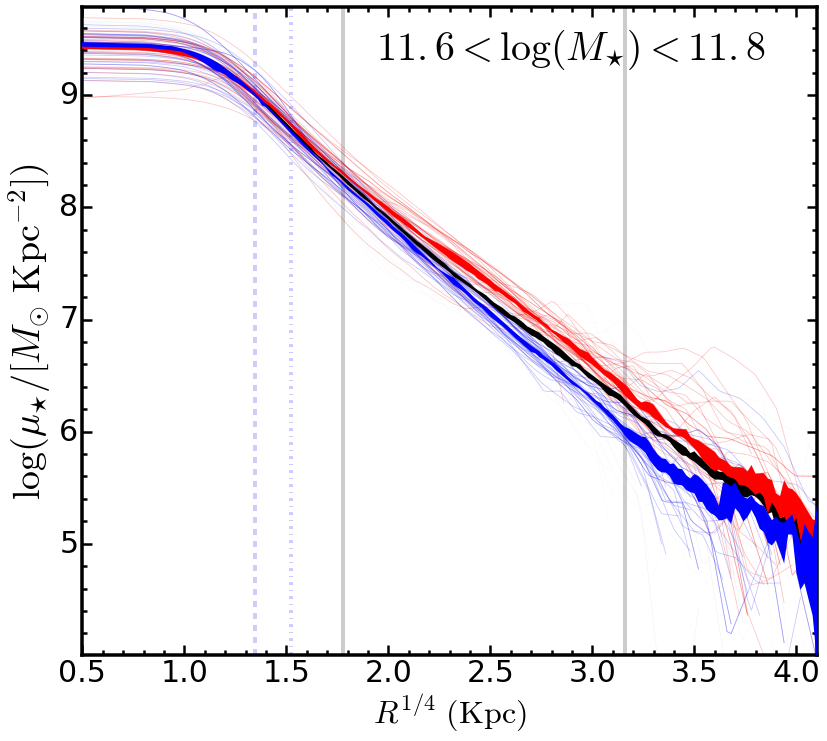

In [108]:
# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='-', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='-', zorder=0, alpha=0.2)

# z = 0.2 : 1"=3.3 Kpc
ax1.axvline(3.3 ** 0.25, linewidth=4.0, c='b', linestyle='--', alpha=0.2, zorder=0)
# z = 0.4 : 1"=5.4 Kpc
ax1.axvline(5.4 ** 0.25, linewidth=4.0, c='b', linestyle='-.', alpha=0.2, zorder=0)

for ss in mpStack:
    ax1.plot(RSMA_COMMON, ss, c='k', alpha=0.02, linewidth=0.8)
for aa in aStack:
    ax1.plot(RSMA_COMMON, aa, c='r', alpha=0.2, linewidth=0.8)
for bb in bStack:
    ax1.plot(RSMA_COMMON, bb, c='b', alpha=0.2, linewidth=0.8)   

ax1.fill_between(RSMA_COMMON, mpMed[0], mpMed[1], 
                 facecolor='k', edgecolor='none', alpha=1.0, zorder=1005)

ax1.fill_between(RSMA_COMMON, aMed[0], aMed[1], 
                 facecolor='r', edgecolor='none', alpha=1.0, zorder=1005)
ax1.fill_between(RSMA_COMMON, bMed[0], bMed[1], 
                 facecolor='b', edgecolor='none', alpha=1.0, zorder=1005)

ax1.text(0.40, 0.90, '$11.6 < \log (M_{\star}) < 11.8$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=40.0, transform=ax1.transAxes)

ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=32)
ax1.set_ylabel('$\log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=38)

ax1.set_xlim(0.5, 4.1)
ax1.set_ylim(4.01, 9.79)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#fig.savefig('hscMassive_mprof_m2a_1.png', dpi=90)